## Part 3

$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}\right) + 5\log \left((1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right)$

- Assuming a flat Universe, we have a parametric non-linear model for $\mu$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. **Fit it to the data, however you want to do it, using tecniques we've seen throughout the course.**
- What are the measured value of $H_0$ and $\Omega_m$? What are theyre errors? Are they correlated? 
- How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)


Flat Universe: $$\Omega_{\Lambda}  = 1 - \Omega_m $$

$$ \mu = 5 log\left( \frac{c/H_0}{10\text{pc}}(1+z)\int_0^{z} 
\frac{dz'}{\sqrt{\Omega_m z'^3 +  1}}\right) $$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [5]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [6]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_7844\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


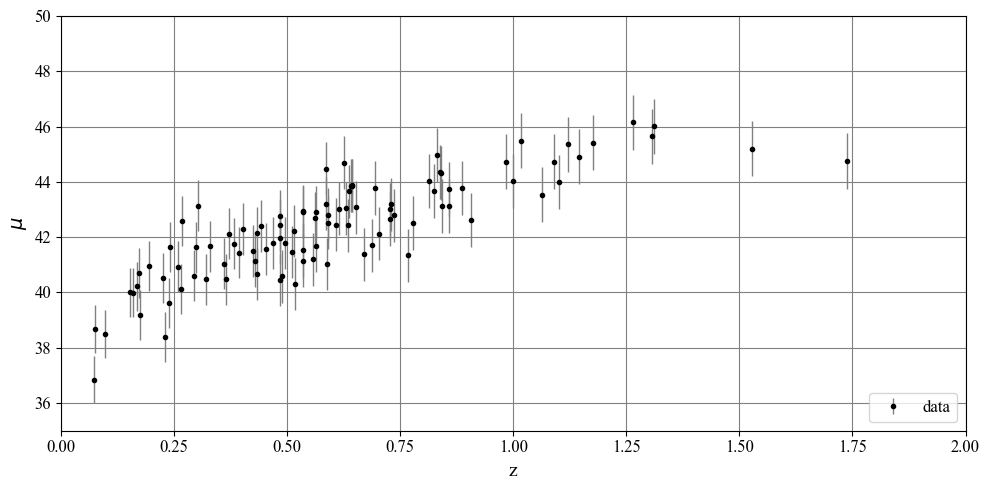

In [7]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

**Fit it to the data, however you want to do it, using tecniques we've seen throughout the course.**\

# MCMC

In [5]:
from scipy.integrate import quad
from scipy.special import gammaln

c = 299792.458  # velocità della luce in km/s
nu = 2

def integrand(zp, omega_m):
    return 1.0 / np.sqrt(omega_m * zp**3 + 1)

def mu_theoretical(z, H0, omega_m):
    mu = []
    for zi in z:
        integral, _ = quad(integrand, 0, zi, args=(omega_m,))
        dL = (c / H0) * (1 + zi) * integral  # luminosity distance in Mpc
        mu_i = 5 * np.log10(dL * 1e6 / 10)   # convert Mpc to pc and apply modulus formula
        mu.append(mu_i)
    return np.array(mu)

def log_likelihood_t(theta):
    H0, omega_m = theta
    if H0 <= 0 or not (0 <= omega_m <= 1):
        return -np.inf

    mu_model = mu_theoretical(z_sample, H0, omega_m)
    residuals = (mu_sample - mu_model) / dmu

    # Calculate log of Student's t PDF for each residual
    part1 = gammaln((nu + 1) / 2) - gammaln(nu / 2)
    part2 = -0.5 * np.log(nu * np.pi)
    part3 = -((nu + 1) / 2) * np.log(1 + (residuals**2) / nu)

    log_pdf = part1 + part2 + part3

    return np.sum(log_pdf)

def log_likelihood(theta):
    H0, omega_m = theta
    if H0 <= 0 or not (0 <= omega_m <= 1):
        return -np.inf
    mu_model = mu_theoretical(z_sample, H0, omega_m)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

def log_prior(theta):
    H0, omega_m = theta
    if 50 < H0 < 100 and 0 < omega_m < 1:
        return 0.0
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_t(theta)

In [6]:
ndim = 2
nwalkers = 20
nsteps = int(1e4)

In [7]:
initial = np.array([70, 0.3])  # H0, Omega_m
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [8]:
import emcee

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [10]:
sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 10000/10000 [22:22<00:00,  7.45it/s]


State([[79.39579634  0.3162213 ]
 [79.90484935  0.14139159]
 [77.29057669  0.51060656]
 [72.7311222   0.64305508]
 [76.33078313  0.25385603]
 [78.24298349  0.71770209]
 [85.31333694  0.27838393]
 [73.54600461  0.73997865]
 [82.19383096  0.99884765]
 [84.35714183  0.59374519]
 [75.47693967  0.32403131]
 [77.42449641  0.36653324]
 [80.77582165  0.75386639]
 [83.30463273  0.47364754]
 [80.37990555  0.54893855]
 [77.15710001  0.89142655]
 [78.53952965  0.63832316]
 [79.84311491  0.44541313]
 [81.50091644  0.61293848]
 [79.1516329   0.44153927]], log_prob=[-152.20575012 -152.27891662 -152.18809915 -153.04216363 -152.44591235
 -152.16531368 -153.35816561 -152.70502719 -153.00157291 -153.33183281
 -152.54736955 -152.23024092 -152.47193303 -152.88943142 -152.31486484
 -152.1629175  -152.1684591  -152.23111456 -152.53835684 -152.18533694], blobs=None, random_state=('MT19937', array([1450641089, 2952230749, 1953234823, 3547751038, 4181955599,
       1897757964, 2995270263, 1797876288, 2403756725

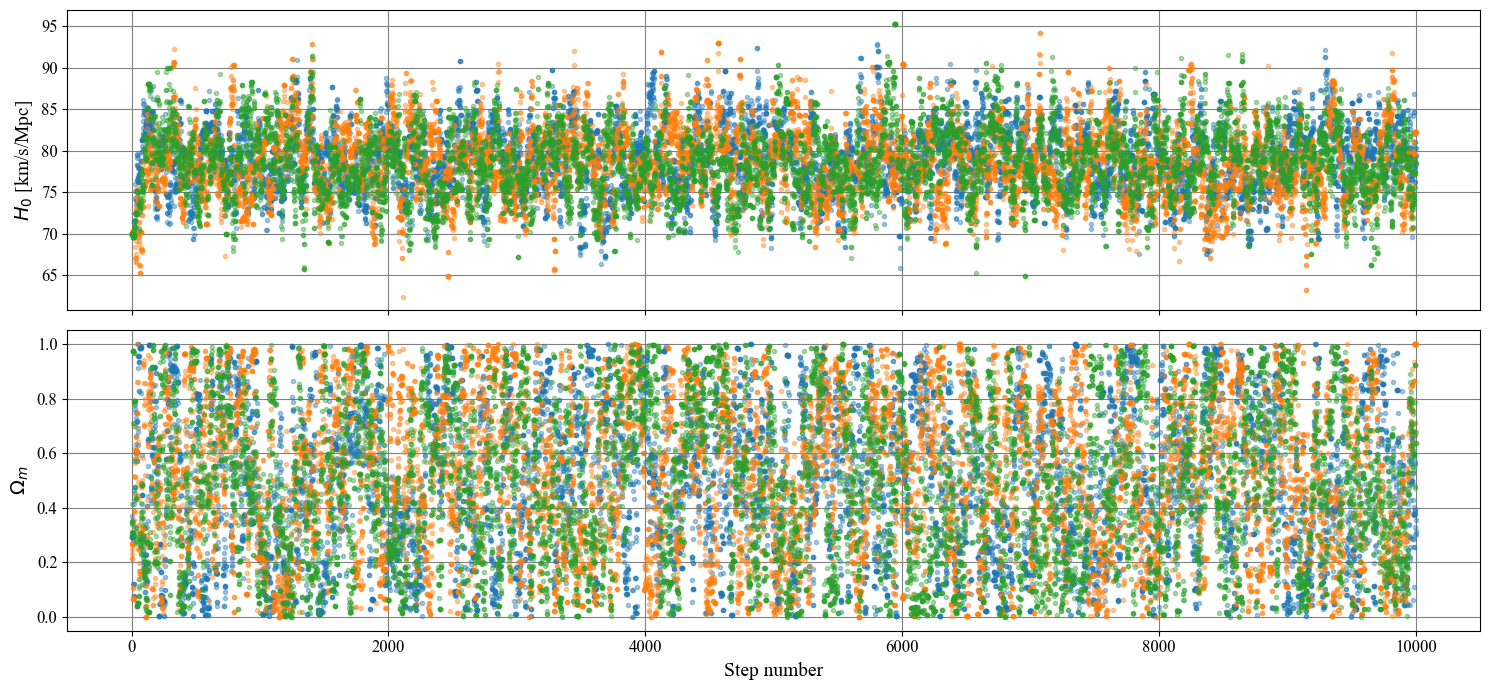

In [11]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"]

# Assuming sampler.get_chain() shape is (n_steps, n_walkers, ndim)
chain = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    # Plot every 8th walker
    for walker in range(0, chain.shape[1], 8):
        ax.plot(chain[:, walker, i], '.', alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel("Step number")
plt.tight_layout()

In [12]:
tau = int(max(sampler.get_autocorr_time()))
flat_samples = sampler.get_chain(discard=100, thin=tau, flat=True)

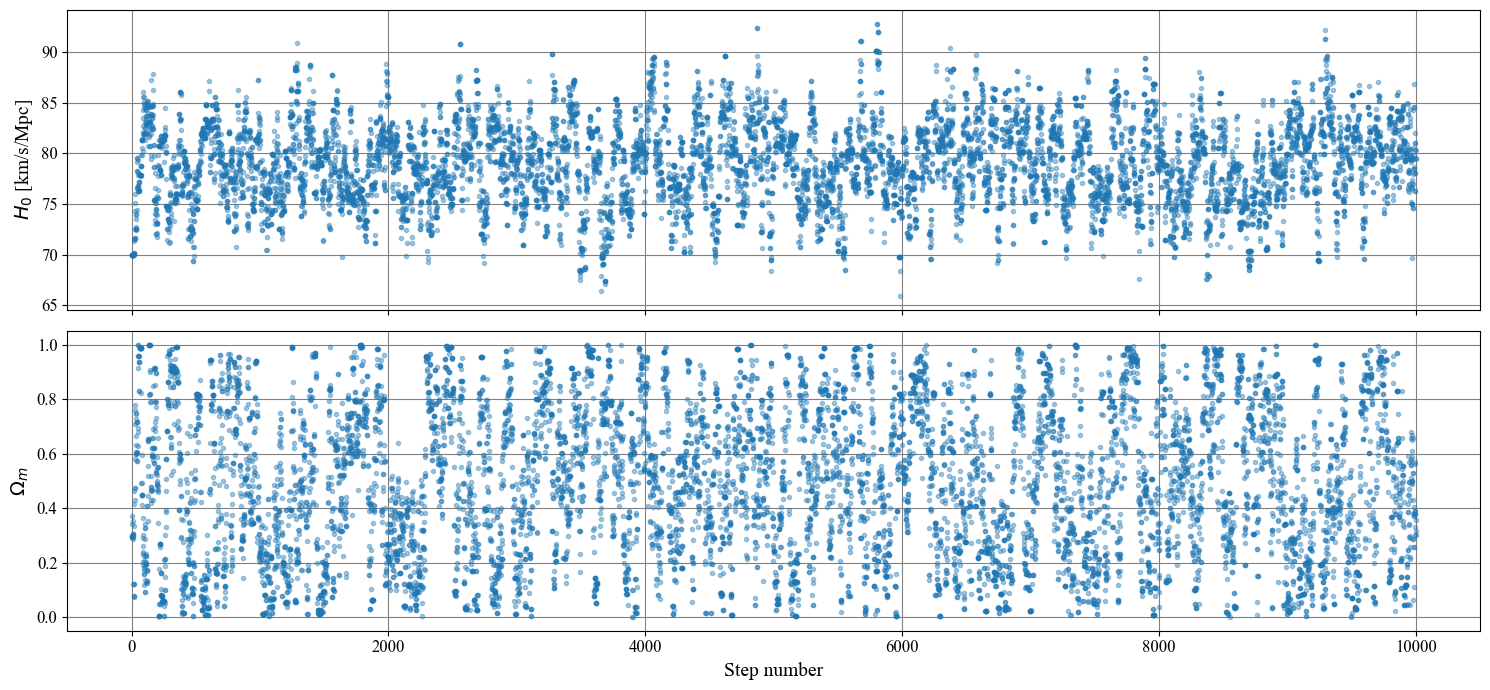

In [13]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"]

for i in range(ndim):
    ax = axes[i]
    # Plot every 8th walker
    for walker in range(0, flat_samples.shape[1], 8):
        ax.plot(chain[:, walker, i], '.', alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [14]:
import corner

<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
C:\Users\ricca\AppData\Local\Temp\ipykernel_18132\2308470797.py:20: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)


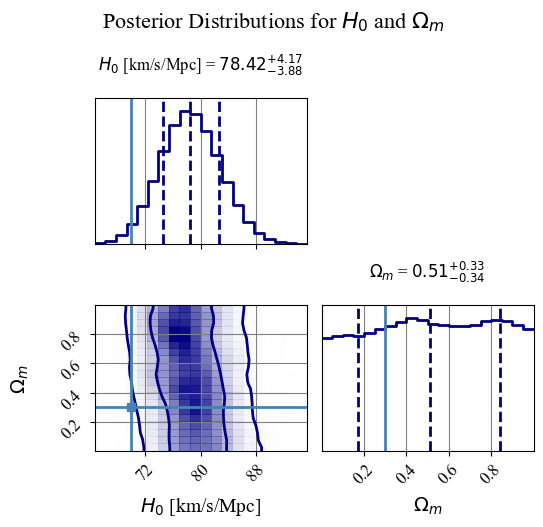

In [15]:
fig = corner.corner(
    flat_samples,
    labels=[r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"],
    truths=[70, 0.3],  # Optional: if you want to show true/expected values
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_contours=True,
    plot_density=True,
    plot_datapoints=False,  # cleaner look
    color="navy",
    smooth=1.0,  # smoothing for density
    smooth1d=1.0,
    figsize=(6, 6),
)

fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)
plt.tight_layout()
plt.show()


As can be seen in the corner plot above, data at disposal do not contain much information on the $\Omega_m$ parameter; this can be deduced looking at the marginal distribution whose shape is given by the uniform prior distribution on $\Omega_m$.  

What are the measured value of $H_0$ and $ \Omega_m$. Are they correlated?

In [16]:
import numpy as np

# Assuming `flat_samples` is of shape (n_samples, 2) → [H0, Omega_m]
param_names = ['H0', 'Omega']
results = []

for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results.append((mcmc[1], q[0], q[1]))
    print(f"{param_names[i]} = {mcmc[1]:.2f} (+{q[1]:.2f}, -{q[0]:.2f})")


H0 = 78.42 (+4.17, -3.88)
Omega = 0.51 (+0.33, -0.34)


In [17]:
corr_matrix = np.corrcoef(flat_samples.T)

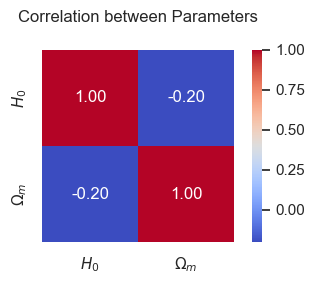

In [18]:
import seaborn as sns

sns.set(style="white")
fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            xticklabels=[r"$H_0$", r"$\Omega_m$"],
            yticklabels=[r"$H_0$", r"$\Omega_m$"],
            cmap="coolwarm", cbar=True, square=True, ax=ax)

plt.title("Correlation between Parameters")
plt.tight_layout()

There is a anticorrelation between the parameter $H_0$ and $\Omega_m$

In [19]:
# Generate smooth z values to plot the model line
z_fit = np.linspace(min(z_sample), max(z_sample), 200)  # or a range covering your data

In [20]:
mu_chain = []
for h0, omega_m in flat_samples[np.random.choice(len(flat_samples), 500, replace=False)]:
    mu_chain.append(mu_theoretical(z_fit, H0=h0, omega_m=omega_m))
mu_chain = np.array(mu_chain)

In [21]:
mu_median = np.median(mu_chain, axis=0)
mu_lower = np.percentile(mu_chain, 16, axis=0)
mu_upper = np.percentile(mu_chain, 84, axis=0)

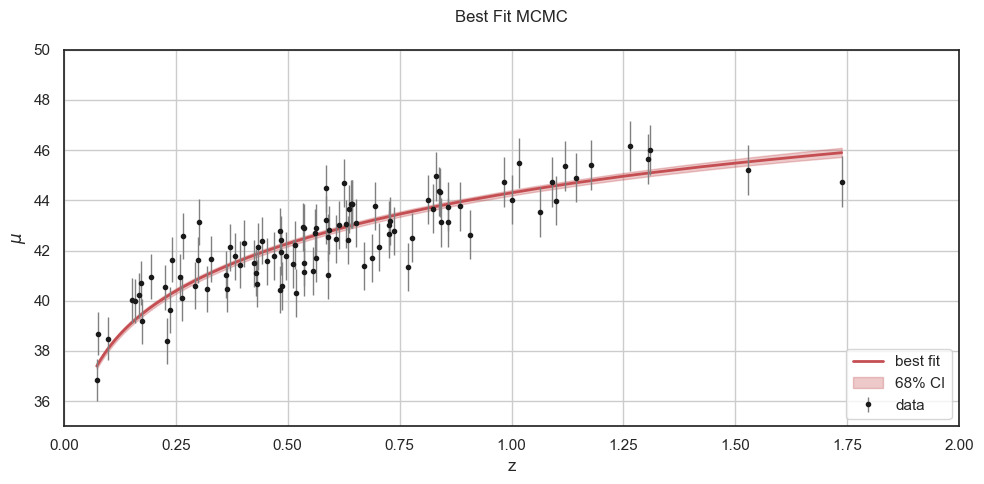

In [22]:
plt.plot(z_fit, mu_median, lw=2, color='r', label='best fit')
plt.fill_between(z_fit, mu_lower, mu_upper, color='r', alpha=0.3, label='68% CI')
plt.title('Best Fit MCMC')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.grid(True)


## Model Selection with Nested Sampling

In [23]:
# === Distance modulus ===
def integrand(zp, omega_m, omega_l):
    val = omega_m * (1 + zp**3) + omega_l
    if val <= 0:
        return 1e100  # prevent crash, return very large value
    return 1.0 / np.sqrt(val)

def mu_theoretical(z, H0, omega_m, omega_l):
    mu = []
    for zi in z:
        try:
            integral, _ = quad(integrand, 0, zi, args=(omega_m, omega_l), limit=200)
            if not np.isfinite(integral):
                mu.append(np.inf)
                continue
            dL = (c / H0) * (1 + zi) * integral
            mu_i = 5 * np.log10(dL * 1e6 / 10)
        except Exception:
            mu_i = np.inf
        mu.append(mu_i)
    return np.array(mu)


# === Log-likelihood with Student's t-distribution ===
def log_likelihood(theta, model):
    if model == "flat":
        H0, omega_m = theta
        if not (50 < H0 < 100) or not (0 < omega_m < 1):
            return -np.inf
        omega_l = 1.0 - omega_m
    elif model == "nonflat":
        H0, omega_m, omega_l = theta
        if not (50 < H0 < 100) or not (0 < omega_m < 1) or not (0 < omega_l < 1):
            return -np.inf
        if omega_m < 0 or omega_l < 0 or omega_m + omega_l > 2:
            return -np.inf
    else:
        raise ValueError("Unknown model: choose 'flat' or 'nonflat'.")

    mu_model = mu_theoretical(z_sample, H0, omega_m, omega_l)
    residuals = (mu_sample - mu_model) / dmu
    part1 = gammaln((nu + 1) / 2) - gammaln(nu / 2)
    part2 = -0.5 * np.log(nu * np.pi)
    part3 = -((nu + 1) / 2) * np.log(1 + (residuals**2) / nu)
    return np.sum(part1 + part2 + part3)

def glog_likelihood(theta, model):
    
    if model == "flat":
        H0, omega_m = theta
        if not (50 < H0 < 100) or not (0 < omega_m < 1):
            return -np.inf
        omega_l = 1.0 - omega_m
    elif model == "nonflat":
        H0, omega_m, omega_l = theta
        if not (50 < H0 < 100) or not (0 < omega_m < 1) or not (0 < omega_l < 1):
            return -np.inf
        if omega_m + omega_l > 2:
            return -np.inf
    else:
        raise ValueError("Unknown model: choose 'flat' or 'nonflat'.")

    mu_model = mu_theoretical(z_sample, H0, omega_m, omega_l)
    residuals = (mu_sample - mu_model) / dmu

    # Standard Gaussian log-likelihood
    return -0.5 * np.sum(residuals**2 + np.log(2 * np.pi * dmu**2))


# === Prior transform ===
def prior_transform(u, model):
    if model == "flat":
        u_H0, u_omega_m = u
        H0 = 50 + 50 * u_H0
        omega_m = u_omega_m
        return H0, omega_m
    elif model == "nonflat":
        u_H0, u_omega_m, u_omega_l = u
        H0 = 50 + 50 * u_H0
        omega_m = u_omega_m
        omega_l = u_omega_l
        return H0, omega_m, omega_l
    else:
        raise ValueError("Unknown model: choose 'flat' or 'nonflat'.")

In [24]:
from dynesty import NestedSampler

# === Run NestedSampler ===
def run_model(model):
    if model == "flat":
        ndim = 2
    elif model == "nonflat":
        ndim = 3
    else:
        raise ValueError("Unknown model")

    sampler = NestedSampler(
        glog_likelihood, prior_transform,
        ndim=ndim,
        logl_args=(model,),
        ptform_args=(model,)
    )
    sampler.run_nested(print_progress=True)
    return sampler.results

In [25]:
res_flat = run_model("flat")

1385it [01:00, 22.86it/s, +500 | bound: 0 | nc: 1 | ncall: 8304 | eff(%): 24.154 | loglstar:   -inf < -133.808 <    inf | logz: -135.698 +/-  0.029 | dlogz:  0.001 >  0.509]


In [26]:
res_nonflat = run_model("nonflat")

1555it [01:16, 20.36it/s, +500 | bound: 0 | nc: 1 | ncall: 10300 | eff(%): 20.969 | loglstar:   -inf < -133.808 <    inf | logz: -136.038 +/-  0.039 | dlogz:  0.001 >  0.509]


In [27]:
def plot_fit_over_data(results, model):
    # Extract samples and log-likelihood from results
    samples = results.samples
    logl = results.logl

    # Find best-fit parameters (max log-likelihood)
    max_idx = np.argmax(logl)
    best_params = samples[max_idx]

    # Unpack parameters depending on model
    if model == "flat":
        H0, omega_m = best_params
        omega_l = 1.0 - omega_m
    else:
        H0, omega_m, omega_l = best_params

    # Compute model mu over a fine z grid
    z_fit = np.linspace(min(z_sample), max(z_sample), 200)
    mu_fit = mu_theoretical(z_fit, H0, omega_m, omega_l)

    # Plot data with error bars
    plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='o', label='Data', alpha=0.6)

    # Plot best-fit model
    plt.plot(z_fit, mu_fit, label=f'Best-fit {model} model', color='red')

    plt.xlabel('Redshift z')
    plt.ylabel('Distance Modulus μ')
    plt.title('Cosmology Fit')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def get_params(results):
    weights = np.exp(results.logwt - results.logz[-1])  # normalized weights
    mean_params = np.average(results.samples, axis=0, weights=weights)
    return mean_params


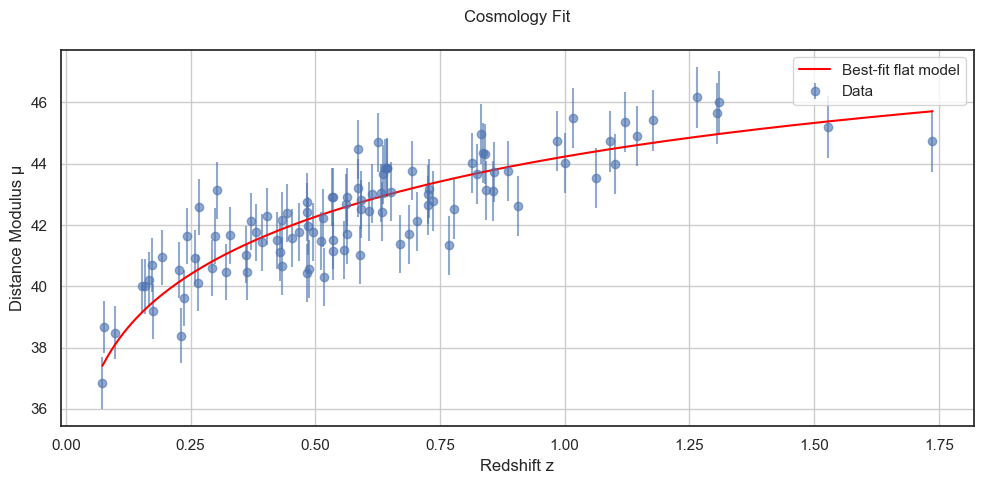

Best-fit parameters: [79.39882995  0.53292432]


In [28]:
plot_fit_over_data(res_flat, model='flat')
best_params = get_params(res_flat)
print("Best-fit parameters:", best_params)

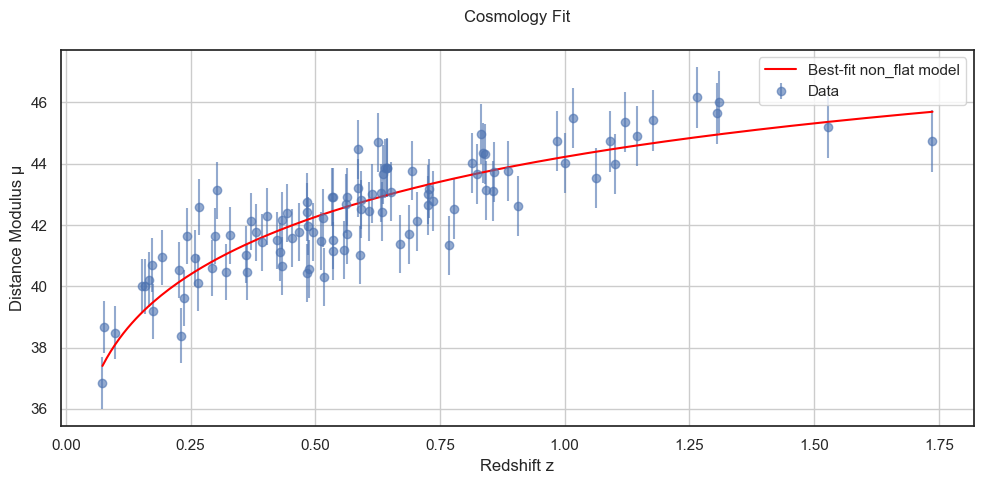

Best-fit parameters: [77.57501408  0.56942453  0.53531755]


In [29]:
plot_fit_over_data(res_nonflat, model='non_flat')
best_params_nf = get_params(res_nonflat)
print("Best-fit parameters:", best_params_nf)

In [30]:
def get_residuals(theta, model):
    if model == "flat":
        H0, omega_m = theta
        omega_l = 1.0 - omega_m
    elif model == "nonflat":
        H0, omega_m, omega_l = theta
    else:
        raise ValueError("Unknown model: choose 'flat' or 'nonflat'.")

    mu_model = mu_theoretical(z_sample, H0, omega_m, omega_l)
    residuals = (mu_sample - mu_model) / dmu
    return residuals

from scipy.stats import skew, kurtosis

def residuals_statistics(residuals):
    mean_res = np.mean(residuals)
    std_res = np.std(residuals, ddof=1)  # sample std dev
    median_res = np.median(residuals)
    skewness = skew(residuals)
    excess_kurtosis = kurtosis(residuals)  # Fisher definition (subtracts 3)
    rms = np.sqrt(np.mean(residuals**2))
    
    print(f"Mean: {mean_res:.4f}")
    print(f"Median: {median_res:.4f}")
    print(f"Std dev: {std_res:.4f}")
    print(f"RMS: {rms:.4f}")
    print(f"Skewness: {skewness:.4f}")
    print(f"Excess Kurtosis: {excess_kurtosis:.4f}")

    return {
        'mean': mean_res,
        'median': median_res,
        'std_dev': std_res,
        'rms': rms,
        'skewness': skewness,
        'excess_kurtosis': excess_kurtosis
    }

In [31]:
theta_flat = best_params
residuals_flat = get_residuals(theta_flat, "flat")

# Example for nonflat model parameters
theta_nonflat = best_params_nf
residuals_nonflat = get_residuals(theta_nonflat, "nonflat")

Mean: 0.0032
Median: 0.0256
Std dev: 0.9789
RMS: 0.9740
Skewness: -0.0635
Excess Kurtosis: -0.2385


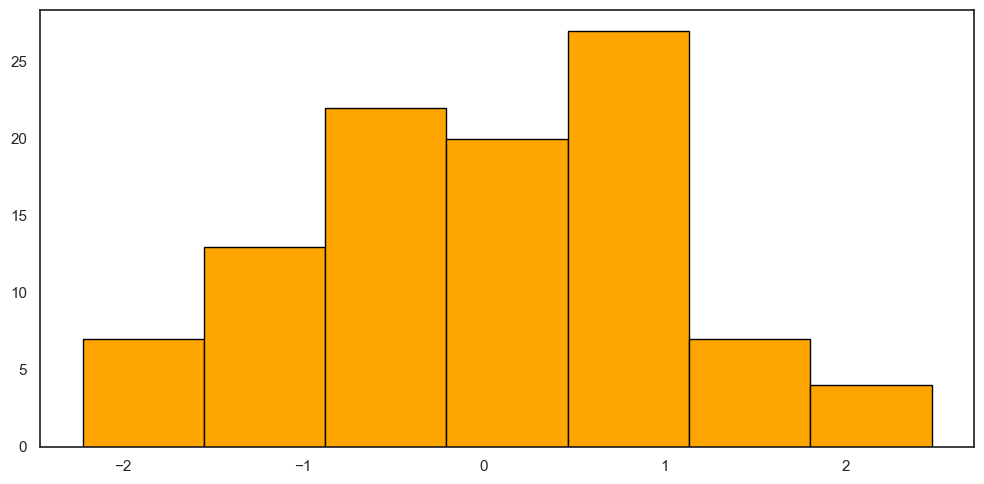

In [32]:
plt.hist(residuals_flat, bins='scott', histtype='barstacked', color='orange', edgecolor='black')
stats = residuals_statistics(residuals_flat)

Mean: 0.0627
Median: 0.0836
Std dev: 0.9793
RMS: 0.9764
Skewness: -0.0615
Excess Kurtosis: -0.2373


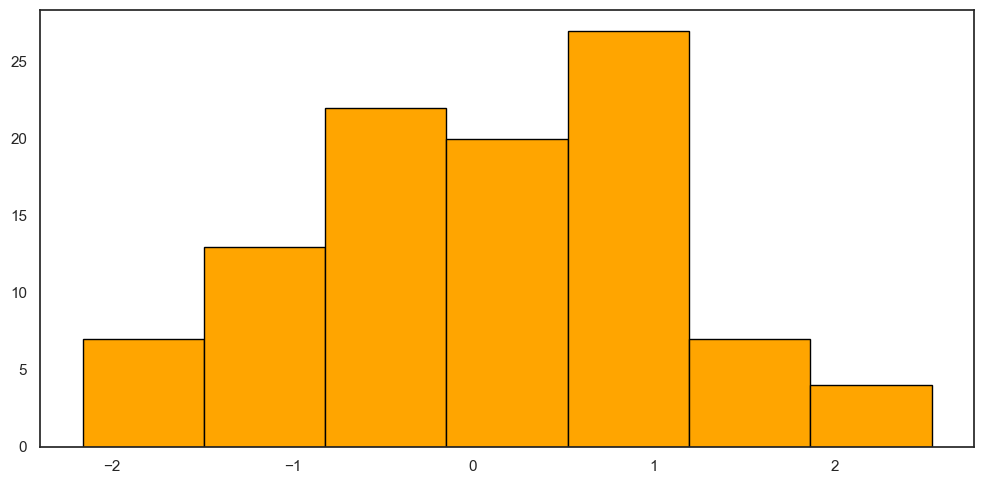

In [33]:
plt.hist(residuals_nonflat, bins='scott', histtype='barstacked', color='orange', edgecolor='black')
stats = residuals_statistics(residuals_nonflat)

In [34]:
# === Run both models and compute Bayes factor ===
logZ_flat = res_flat.logz[-1]
logZ_nonflat = res_nonflat.logz[-1]
logB = logZ_flat - logZ_nonflat

print(f"logZ (flat)     = {logZ_flat:.2f}")
print(f"logZ (nonflat)  = {logZ_nonflat:.2f}")
print(f"Bayes factor (flat vs nonflat): {np.exp(logB):.2f}")

logZ (flat)     = -135.70
logZ (nonflat)  = -136.04
Bayes factor (flat vs nonflat): 1.40


According to Jeffrey's scale:\
Using not gaussian errors $(nu = 2) \to$**There is weak evidence for a flat universe!**\
Using  gaussian errors $\to$ **Difference is barely worth mentioning!**\

Looking at residuals statistics I can conclude that gaussian error approximation is solid. Thus the difference between the models (given this particular realization of the data) is barely worth mentioning.